# FX Momentum Backtest (EM basket)



In [1]:
from src.data_request import BloombergAPI
from datetime import datetime
import pandas as pd
import numpy  as np

import warnings
warnings.filterwarnings('ignore')

index_specifications = {'NMFXBRL Index' : {'Symbol':'NMFXBRL Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                        'NMFXCNY Index' : {'Symbol':'NMFXCNY Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                        'NMFXCNH Index' : {'Symbol':'NMFXCNH Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                        'NMFXINR Index' : {'Symbol':'NMFXINR Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                        'NMFXKRW Index' : {'Symbol':'NMFXKRW Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                        'NMFXMXN Index' : {'Symbol':'NMFXMXN Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                        'NMFXPLN Index' : {'Symbol':'NMFXPLN Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                        'NMFXRUB Index' : {'Symbol':'NMFXRUB Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                        'NMFXSGD Index' : {'Symbol':'NMFXSGD Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                        'NMFXTRY Index' : {'Symbol':'NMFXTRY Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                        'NMFXZAR Index' : {'Symbol':'NMFXZAR Index', 'Weight' : 1.0/11.0 , 'Vol_Scale_Cap':4.00},
                       }

symbols = [ index_specifications[s]['Symbol'] for s in list(index_specifications.keys())]


benchmarks = ['NMEMMOMU Index']


In [2]:
print('Selected symbols are: ',symbols)

Selected symbols are:  ['NMFXBRL Index', 'NMFXCNY Index', 'NMFXCNH Index', 'NMFXINR Index', 'NMFXKRW Index', 'NMFXMXN Index', 'NMFXPLN Index', 'NMFXRUB Index', 'NMFXSGD Index', 'NMFXTRY Index', 'NMFXZAR Index']


# Data Exploration

The data we use here comes from Bloomberg. The code below utilizes the Bloombergs Python API to pull data directly from Bloombergs servers. After downloading the data lets plot the it to make sure it makes sense :)

In [3]:
# Download data for traded instruments
data_handler = BloombergAPI(SERVER_HOST='localhost',SERVER_PORT=8194)
start_date   = datetime(1990,1,1)
end_date     = datetime.today()
price_data   = []
for symbol in symbols:
    print('Downloading data for symbol :',symbol)
    try:
        data = data_handler.send_request([symbol],["PX_LAST"],start_date,end_date)
        if(len(data[symbol])!=0):
            f = pd.DataFrame.from_dict(data[symbol],orient='index')
            f.columns = [symbol]
            price_data.append(f.copy())
    except:
        print(f"Could not download data for {symbol}")

price_data       = pd.concat(price_data,axis=1)
price_data.index = pd.DatetimeIndex(price_data.index)

# Download data for benchmark indices
benchmark_data   = []
for symbol in benchmarks:
    print('Downloading data for symbol :',symbol)
    try:
        data = data_handler.send_request([symbol],["PX_LAST"],start_date,end_date)
        if(len(data[symbol])!=0):
            f = pd.DataFrame.from_dict(data[symbol],orient='index')
            f.columns = [symbol]
            benchmark_data.append(f.copy())
    except:
        print(f"Could not download data for {symbol}")
benchmark_data = pd.concat(benchmark_data,axis=1)
benchmark_data.index = pd.DatetimeIndex(benchmark_data.index)


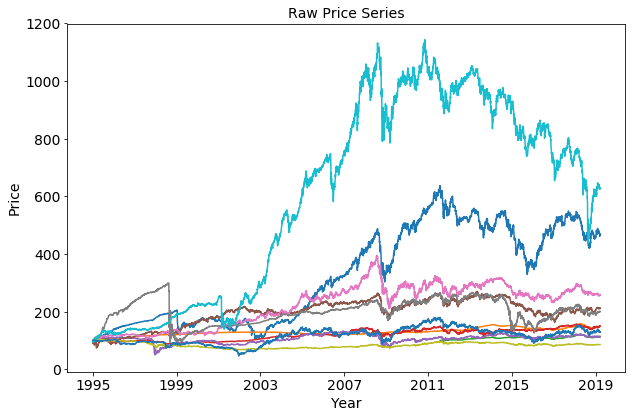

In [5]:
# Lets plot the data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6.4))
plt.plot(price_data)
plt.ylabel('Price',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Raw Price Series',fontsize=14)
plt.show()


# Momentum Signal Definitions

The momentum signal for some asset $i$ is here defined as the simple average of scaled individual signals. The process of computing the scaled signals begins by first computing raw unscaled signals. These unscaled signals are then scaled using some normalization method.

# Signal 1:

The first signal that we test is simple average of realized Sharpe ratios. Each individual raw unscaled signal, $\tilde{s}_{i,w}(t)$, for asset $i$ and lookback $w$ is computed as the ratio of average of lagged $w$ returns, $\mu_{i,w}(t)$, divided by the standard deviation $\sigma(\mu_{i,w})(t)$. The average of lagged returns is:

$$\mu_{i,w}(t)=\frac{1}{w}\sum_{j=0}^{w}r_{i,t-j}$$

The problem with the raw signals $\mu_{i,w}(t)$ are that they have different variances and therefore they have different contributions to the final signal. In order to mitigate this problem we need to scale them to have similar variances. In the case of our first signal, the scaled signal is obtained by dividing the raw signal by its own 1250 day (approx. 5 trading years) standard deviation $\sigma_{1250}(\mu_{i,w})$, i.e.:

$$\tilde{s}_{i,w}(t)=Max\left(-1;Min\left(1;\frac{\mu_{i,w}(t)}{\sigma_{1250}(\mu_{i,w})(t)}\right)\right)$$

Additionally, we impose limits to the magnitude of signal such that $s_{i,w}(t) \in \left[ -1,1\right]$ to prohibit excessive positions. The final trading signal is then obtained by averaging the raw signals for each $w$:

$$s_i(t)=\sum_{j=1}^{3}s_{i,w_j}(t)$$


# Signal 2:
 
The second signal is computed like Signal 1 but we impose extra cutoff level of $\xi$. In other words - we trade only when the signal is strong enough.

$$s_{w}(t)=\left\{\begin{matrix}
s_{w}(t), \left | s_{w}(t) \right | \geq \xi \\ 
0
\end{matrix}\right.$$


# Signal 3:
Like signal 1 but with total returns.



# Signal 4:
Signal 4 is such that between +-20% proportional to signal, if over +-20% in absolute value the signal is +-100%.

$$s_{w}(t)=\left\{\begin{matrix}
+100\% , s_{w}(t) > 20\% \\ 
s_{w}(t) , \left| s_{w}(t) \right| \leq 20\% \\ 
-100\% , s_{w}(t) < -20\%
\end{matrix}\right.$$


# Signal 5:
Signal 5 is based on the cross over of short and longer exponentially weighted moving averages of the futures $\textit{prices}$. The algorithm building this signal involves several steps:

(a) Select 3 sets of time-scales with each set consisting of a short and a long ewmas.

(b) Here, we use the same specs as in MAN AHLs paper (link below). Let

$$S_k=\left( 8,16,32\right)$$
$$L_k=\left( 24,48,96\right)$$

These numbers are not look-back days or half-lifes but translate into EWMA decay factors $\lambda(n) = \frac{n-1}{n}$. So decay for the first short EWMA is $\lambda(S_1) = \frac{S_1-1}{S_1} = \frac{8-1}{8}$. Using this decay factor we compute the half-life of the EWMA:

$$HL(n) = \frac{log(0.5)}{log(\lambda(n))}$$

(c) Once we have obtained HLs for $S_k$ and $L_k$ we compute the cross over magnitudes $x_k$ in the usual manner:

$$x_k = EWMA\left(P|S_k\right) - EWMA\left(P|L_k\right)$$

where $P$ is the time-series for the price of the futures.

(d) The raw cross over signals $x_k$ is then normalized using a moving standard deviation of the $\textit{futures}$ $\textit{price}$ which is computed over 63-trading days:

$$y_k = \frac{x_k}{\sigma(P)_{63}}$$

Shameless plug warning:  https://www.cmegroup.com/education/files/dissecting-investment-strategies-in-the-cross-section-and-time-series.pdf

(e) The standardized signal $y_k$ is standardized again using its own standard deviation computed over 252 trading days:

$$z_k = \frac{y_k}{\sigma(y_k)_{252}}$$

(f) The final signal $s$ is obtained by averaging the three standardized signals:

$$s=\frac{1}{3}\sum_{k=1}^{3} z_k $$

(g) Finally, we truncate the signal $s\in \left[ -1;1\right]$

In [14]:
def signal_1(symbol,returns,return_lookback_windows,sigma_lookback_window):
    t = {}
    for w in return_lookback_windows:
        mu = returns.rolling(w).mean()
        s  = (mu.div(mu.rolling(sigma_lookback_window).std())).clip(-1,1)
        t.update({w:s.copy()})
    df = pd.DataFrame.from_dict(t,orient='columns').mean(axis=1)
    df.columns = [symbol]
    return df
    
def signal_2(symbol,returns,return_lookback_windows,sigma_lookback_window,cutoff):
    s_2 = signal_1(symbol,returns,return_lookback_windows,sigma_lookback_window)
    s_2[abs(s_2)<cutoff] = 0
    return s_2


def signal_3(symbol,price_data,return_lookback_windows,sigma_lookback_window):
    t = {}
    for w in return_lookback_windows:
        r_w   = price_data.pct_change(w)
        sigma = r_w.rolling(sigma_lookback_window).std()
        s     = (r_w.div(sigma)).clip(-1,1)
        t.update({w:s.copy()})
    df = pd.DataFrame.from_dict(t,orient='columns').mean(axis=1)
    df.columns = [symbol]        
    return df

def signal_4(symbol,returns,return_lookback_windows,sigma_lookback_window):
    t = {}
    for w in return_lookback_windows:
        mu    = returns.ewm(w).mean()   
        sigma = mu.ewm(sigma_lookback_window).std()
        s     = mu.div(sigma)
        s[s> 0.2] =  1
        s[s<-0.2] = -1
        t.update({w:s.copy()})
    df = pd.DataFrame.from_dict(t,orient='columns').mean(axis=1)
    df.columns = [symbol]      
    return df


def signal_5(symbol,price_data,shorter_windows,longer_windows):
    
    if(len(shorter_windows)!=len(longer_windows)):
        raise ValueError('Window lengths must be of equal size!')
    else:
        t = {}
        for i in range(0,len(shorter_windows)):
            n_s_k = shorter_windows[i]
            n_l_k = longer_windows[i]
            lamda_s_k = (n_s_k - 1)/float(n_s_k)
            lamda_l_k = (n_l_k - 1)/float(n_l_k)
            hl_s_k = np.log(0.5)/np.log(lamda_s_k)
            hl_l_k = np.log(0.5)/np.log(lamda_l_k)
            ewma_s_k = price_data.ewm(halflife=hl_s_k,ignore_na=True).mean()
            ewma_l_k = price_data.ewm(halflife=hl_l_k,ignore_na=True).mean()
            x_k = ewma_s_k - ewma_l_k
            y_k = x_k/price_data.ewm(63).std()
            z_k = (y_k/y_k.ewm(250).std()).clip(-1,1)
            t.update({f'{shorter_windows[i]}-{longer_windows[i]}':z_k})
        df = pd.DataFrame.from_dict(t,orient='columns').mean(axis=1)
        df.columns = [symbol]
        return df

Lets plot the signals for sanity checking ....

In [17]:
# Return computation
ret = price_data.pct_change(1)

lookback_windows = [66,132,250]

# We allocate dictionary for the signal dataframes
momentum_signals = {}

# Signal 1
t = {}
for symbol in symbols:
    t.update({symbol:signal_1(symbol,ret[symbol],lookback_windows,1250)})
momentum_signals.update({"Signal_1":t})

# Signal 2
t = {}
for symbol in symbols:
    t.update({symbol:signal_2(symbol,ret[symbol],lookback_windows,1250,0.65)})
momentum_signals.update({"Signal_2":t})
    
# Signal 3 (Note: we pass price data here - not returns)
t = {}
for symbol in symbols:
    t.update({symbol:signal_3(symbol,price_data[symbol],lookback_windows,1250)})
momentum_signals.update({"Signal_3":t})

# Signal 4
t = {}
for symbol in symbols:
    t.update({symbol:signal_4(symbol,ret[symbol],lookback_windows,1250)})
momentum_signals.update({"Signal_4":t})

# Signal 5 (Note: we pass price data here - not returns)
t = {}
s_w = [8,16,32]
l_w = [24,48,96]
for symbol in symbols:
    t.update({symbol:signal_5(symbol,price_data[symbol],s_w,l_w)})
momentum_signals.update({"Signal_5":t})




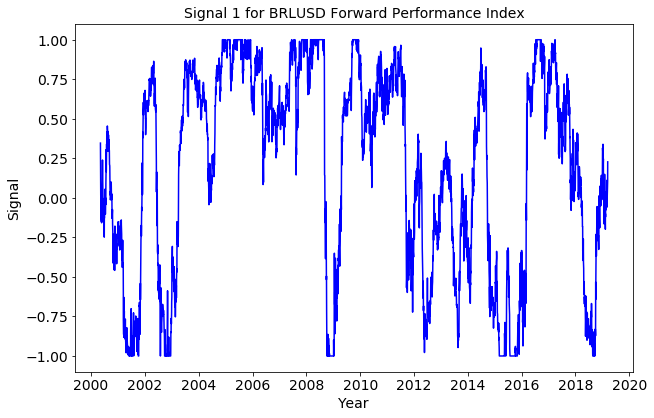

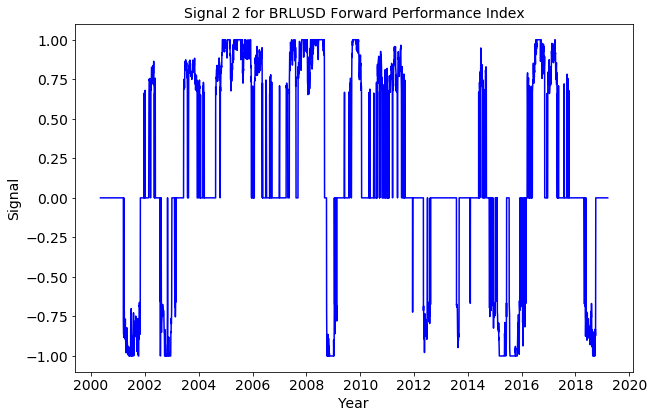

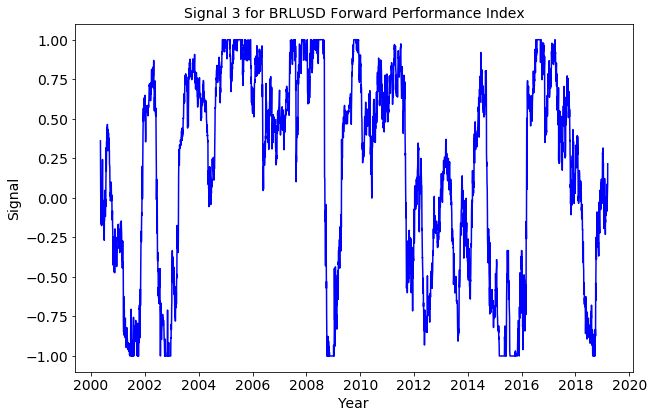

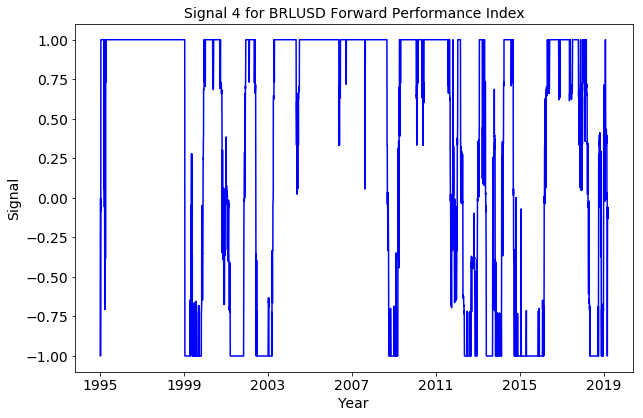

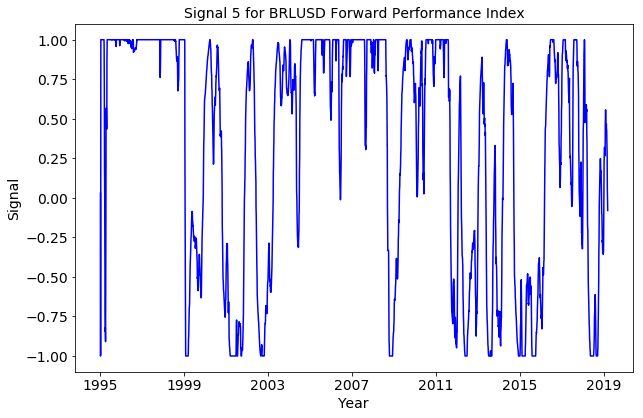

In [16]:
import matplotlib.pyplot as plt

def plot_signal(signal_name,symbol,caption):

    signal_data = pd.DataFrame.from_dict(momentum_signals[signal_name][symbol],orient='columns').dropna()

    fig = plt.figure(figsize=(10,6.4))
    plt.plot(signal_data,color='blue')
    plt.ylabel('Signal',fontsize=14)
    plt.xlabel('Year',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'{caption}',fontsize=14)
    plt.show()

def plot_signal_difference(signal_name_1,signal_name_2,symbol,caption):
    
    s_1 = pd.DataFrame.from_dict(momentum_signals[signal_name_1][symbol],orient='columns').dropna()
    s_2 = pd.DataFrame.from_dict(momentum_signals[signal_name_2][symbol],orient='columns').dropna()
    
    difference = s_1 - s_2
    
    fig = plt.figure(figsize=(10,6.4))
    plt.plot(difference,color='red')
    plt.ylabel(f'{signal_name_1}-{signal_name_2}',fontsize=14)
    plt.xlabel('Year',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'{caption}',fontsize=14)
    plt.show()    
    
    
plot_signal("Signal_1","NMFXBRL Index" ,"Signal 1 for BRLUSD Forward Performance Index")
plot_signal("Signal_2","NMFXBRL Index" ,"Signal 2 for BRLUSD Forward Performance Index")
plot_signal("Signal_3","NMFXBRL Index" ,"Signal 3 for BRLUSD Forward Performance Index")
plot_signal("Signal_4","NMFXBRL Index" ,"Signal 4 for BRLUSD Forward Performance Index")
plot_signal("Signal_5","NMFXBRL Index" ,"Signal 5 for BRLUSD Forward Performance Index")


# Volatility Scaling:

$$L_{t}=Min\left[ C_t ;\frac{\sigma_T}{\sigma_{60} \sqrt{250}} \right]$$

where $\sigma_T = \textit{volatility  target}$ the leverage "cap" $C_t$ is given by:

$$C_{t}=Min\left[ 400 \% ; 75^{th} \textit{ percentile of} \left(\frac{\sigma_T}{\sigma_{60} \sqrt{250}}\right) \right]$$

where $\sigma_T$ is our target volatility which is here set to 8\% p.a. and $\sigma$ is the realized daily volatility. Here we use 60 day trailing window to calculate the realized daily volatility.


In [7]:
# Target volatility (per annum)
target_volatility = 0.08

# volatility calculation window
sigma_window = 60

# Lets compute the volatility leverages for each individual underlying
sigma_ratios_and_caps = {}
for symbol in symbols:
    
    print('Computing volatility scaling for symbol: ', symbol)
    
    # Volatility scaling
    sigma_ratio = target_volatility/(ret[symbol].rolling(sigma_window).std().dropna()*np.sqrt(250))
  
    # Next, we compute 75th percentile of the volatility scaling for each trading day utilizing all the data
    # that would have been available for that date (including the calculation date)
    perc = pd.DataFrame(index = sigma_ratio.index, data = [], columns = [symbol])
    for date in sigma_ratio.index:
        #print(date)
        perc.loc[date] = sigma_ratio.loc[:date].quantile(q=0.75)
    
    # Leverage cap C_t
    C_t = perc.clip(0,4)
    
    tmp = pd.concat([C_t,sigma_ratio],axis=1)
    tmp.columns = ['C_t','Sigma Ratio']
    sigma_ratios_and_caps.update({symbol:tmp.copy()})

L_sigmas = {}    
for symbol in symbols:
    L_sigmas.update({symbol:sigma_ratios_and_caps[symbol].min(axis=1)})


Computing volatility scaling for symbol:  NMFXBRL Index
Computing volatility scaling for symbol:  NMFXCNY Index
Computing volatility scaling for symbol:  NMFXCNH Index
Computing volatility scaling for symbol:  NMFXINR Index
Computing volatility scaling for symbol:  NMFXKRW Index
Computing volatility scaling for symbol:  NMFXMXN Index
Computing volatility scaling for symbol:  NMFXPLN Index
Computing volatility scaling for symbol:  NMFXRUB Index
Computing volatility scaling for symbol:  NMFXSGD Index
Computing volatility scaling for symbol:  NMFXTRY Index
Computing volatility scaling for symbol:  NMFXZAR Index


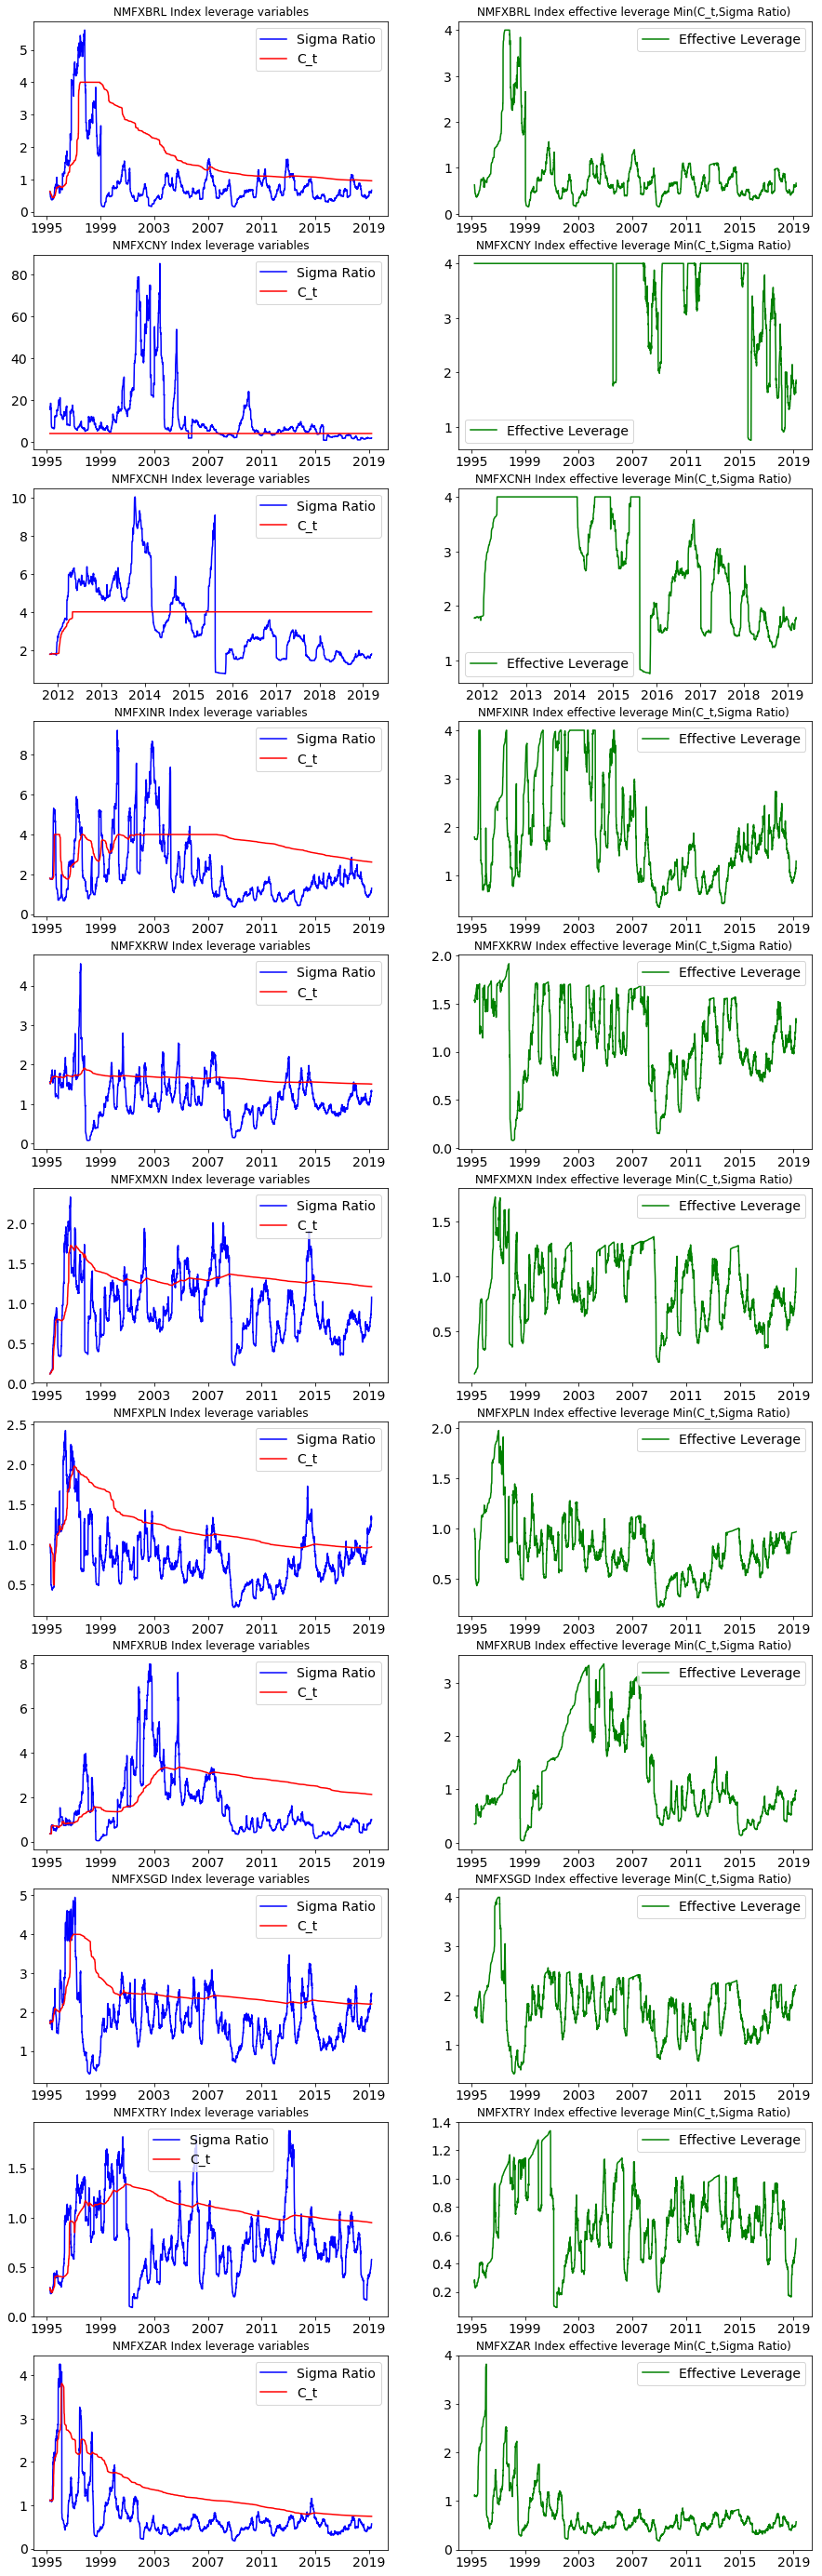

In [98]:
# Plot results
fig, ax = plt.subplots(11, 2, figsize=(15,50))

# NMFXBRL Index Leverage Plots
symbol = 'NMFXBRL Index'
ax[0, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[0, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[0, 0].set_title(f"{symbol} leverage variables" )
ax[0, 0].legend(fontsize=14)
ax[0, 0].xaxis.set_tick_params(labelsize=14)
ax[0, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[0, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[0, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[0, 1].legend(fontsize=14)
ax[0, 1].xaxis.set_tick_params(labelsize=14)
ax[0, 1].yaxis.set_tick_params(labelsize=14)

# NMFXBRL Index Leverage Plots
symbol = 'NMFXCNY Index'
ax[1, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[1, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[1, 0].set_title(f"{symbol} leverage variables" )
ax[1, 0].legend(fontsize=14)
ax[1, 0].xaxis.set_tick_params(labelsize=14)
ax[1, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[1, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[1, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[1, 1].legend(fontsize=14)
ax[1, 1].xaxis.set_tick_params(labelsize=14)
ax[1, 1].yaxis.set_tick_params(labelsize=14)

# NMFXBRL Index Leverage Plots
symbol = 'NMFXCNH Index'
ax[2, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[2, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[2, 0].set_title(f"{symbol} leverage variables" )
ax[2, 0].legend(fontsize=14)
ax[2, 0].xaxis.set_tick_params(labelsize=14)
ax[2, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[2, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[2, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[2, 1].legend(fontsize=14)
ax[2, 1].xaxis.set_tick_params(labelsize=14)
ax[2, 1].yaxis.set_tick_params(labelsize=14)

# NMFXBRL Index Leverage Plots
symbol = 'NMFXINR Index'
ax[3, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[3, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[3, 0].set_title(f"{symbol} leverage variables" )
ax[3, 0].legend(fontsize=14)
ax[3, 0].xaxis.set_tick_params(labelsize=14)
ax[3, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[3, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[3, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[3, 1].legend(fontsize=14)
ax[3, 1].xaxis.set_tick_params(labelsize=14)
ax[3, 1].yaxis.set_tick_params(labelsize=14)

# NMFXBRL Index Leverage Plots
symbol = 'NMFXKRW Index'
ax[4, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[4, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[4, 0].set_title(f"{symbol} leverage variables" )
ax[4, 0].legend(fontsize=14)
ax[4, 0].xaxis.set_tick_params(labelsize=14)
ax[4, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[4, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[4, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[4, 1].legend(fontsize=14)
ax[4, 1].xaxis.set_tick_params(labelsize=14)
ax[4, 1].yaxis.set_tick_params(labelsize=14)

# NMFXBRL Index Leverage Plots
symbol = 'NMFXMXN Index'
ax[5, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[5, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[5, 0].set_title(f"{symbol} leverage variables" )
ax[5, 0].legend(fontsize=14)
ax[5, 0].xaxis.set_tick_params(labelsize=14)
ax[5, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[5, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[5, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[5, 1].legend(fontsize=14)
ax[5, 1].xaxis.set_tick_params(labelsize=14)
ax[5, 1].yaxis.set_tick_params(labelsize=14)

# NMFXBRL Index Leverage Plots
symbol = 'NMFXPLN Index'
ax[6, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[6, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[6, 0].set_title(f"{symbol} leverage variables" )
ax[6, 0].legend(fontsize=14)
ax[6, 0].xaxis.set_tick_params(labelsize=14)
ax[6, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[6, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[6, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[6, 1].legend(fontsize=14)
ax[6, 1].xaxis.set_tick_params(labelsize=14)
ax[6, 1].yaxis.set_tick_params(labelsize=14)

# NMFXBRL Index Leverage Plots
symbol = 'NMFXRUB Index'
ax[7, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[7, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[7, 0].set_title(f"{symbol} leverage variables" )
ax[7, 0].legend(fontsize=14)
ax[7, 0].xaxis.set_tick_params(labelsize=14)
ax[7, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[7, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[7, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[7, 1].legend(fontsize=14)
ax[7, 1].xaxis.set_tick_params(labelsize=14)
ax[7, 1].yaxis.set_tick_params(labelsize=14)

# NMFXBRL Index Leverage Plots
symbol = 'NMFXSGD Index'
ax[8, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[8, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[8, 0].set_title(f"{symbol} leverage variables" )
ax[8, 0].legend(fontsize=14)
ax[8, 0].xaxis.set_tick_params(labelsize=14)
ax[8, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[8, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[8, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[8, 1].legend(fontsize=14)
ax[8, 1].xaxis.set_tick_params(labelsize=14)
ax[8, 1].yaxis.set_tick_params(labelsize=14)

# NMFXBRL Index Leverage Plots
symbol = 'NMFXTRY Index'
ax[9, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[9, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[9, 0].set_title(f"{symbol} leverage variables" )
ax[9, 0].legend(fontsize=14)
ax[9, 0].xaxis.set_tick_params(labelsize=14)
ax[9, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[9, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[9, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[9, 1].legend(fontsize=14)
ax[9, 1].xaxis.set_tick_params(labelsize=14)
ax[9, 1].yaxis.set_tick_params(labelsize=14)

# NMFXBRL Index Leverage Plots
symbol = 'NMFXZAR Index'
ax[10, 0].plot(sigma_ratios_and_caps[symbol]["Sigma Ratio"], label = "Sigma Ratio", color = 'blue')
ax[10, 0].plot(sigma_ratios_and_caps[symbol]["C_t"], label = "C_t", color = 'red')
ax[10, 0].set_title(f"{symbol} leverage variables" )
ax[10, 0].legend(fontsize=14)
ax[10, 0].xaxis.set_tick_params(labelsize=14)
ax[10, 0].yaxis.set_tick_params(labelsize=14)

# TODO: scale left and right y-axes to have similar values
ax[10, 1].plot(sigma_ratios_and_caps[symbol].min(axis=1), label = "Volatility based leverage", color = 'green')
ax[10, 1].set_title(f'{symbol} effective leverage Min(C_t,Sigma Ratio) ')
ax[10, 1].legend(fontsize=14)
ax[10, 1].xaxis.set_tick_params(labelsize=14)
ax[10, 1].yaxis.set_tick_params(labelsize=14)

# Raw Risk Weight

Raw risk weight for asset $i$ at time $t$,$w_{t}^{i}$, is defined as:

$$ w_t^{i} = Min \left[ C_t^{i}, \frac{\sigma_{RiskWeight}}{\sigma_{t,60}^{i}} \right] $$


$\sigma^{T}=\textit{risk weight volatility target}$, $\sigma_{t,60}^{i}$ is $\textit{}$ leverage cap, $C_t^{i}$ for asset $i$ at time $t$ is:

$$ w_R = Min \left[ 300 \% ; 75^{th} \textit{ percentile of} \left[ \frac{\sigma^{T}}{\sigma_{60}^{i}} \right]_t \right] $$


where 


In [8]:
# Target volatility (per annum)
rw_target_volatility = 0.10

# Lets compute the volatility leverages for each individual underlying
rw_sigma_ratios_and_caps = {}
for symbol in symbols:
    
    print('Computing raw risk weight for symbol: ', symbol)
    
    # Volatility scaling
    rw_sigma_ratio = rw_target_volatility/(ret[symbol].rolling(60).std().dropna()*np.sqrt(250))
  
    # Next, we compute 75th percentile of the volatility scaling for each trading day utilizing all the data
    # that would have been available for that date (including the calculation date)
    perc = pd.DataFrame(index = rw_sigma_ratio.index, data = [], columns = [symbol])
    for date in sigma_ratio.index:
        #print(date)
        perc.loc[date] = rw_sigma_ratio.loc[:date].quantile(q=0.75)
    
    # Risk Weight Leverage cap C_t
    rwC_t = perc.clip(0,3)
    
    tmp = pd.concat([rwC_t,rw_sigma_ratio],axis=1)
    tmp.columns = ['rwC_t','rw Sigma Ratio']
    rw_sigma_ratios_and_caps.update({symbol:tmp.copy()})

rws = {}    
for symbol in symbols:
    rws.update({symbol:rw_sigma_ratios_and_caps[symbol].min(axis=1)})

Computing volatility scaling for symbol:  NMFXBRL Index
Computing volatility scaling for symbol:  NMFXCNY Index
Computing volatility scaling for symbol:  NMFXCNH Index
Computing volatility scaling for symbol:  NMFXINR Index
Computing volatility scaling for symbol:  NMFXKRW Index
Computing volatility scaling for symbol:  NMFXMXN Index
Computing volatility scaling for symbol:  NMFXPLN Index
Computing volatility scaling for symbol:  NMFXRUB Index
Computing volatility scaling for symbol:  NMFXSGD Index
Computing volatility scaling for symbol:  NMFXTRY Index
Computing volatility scaling for symbol:  NMFXZAR Index


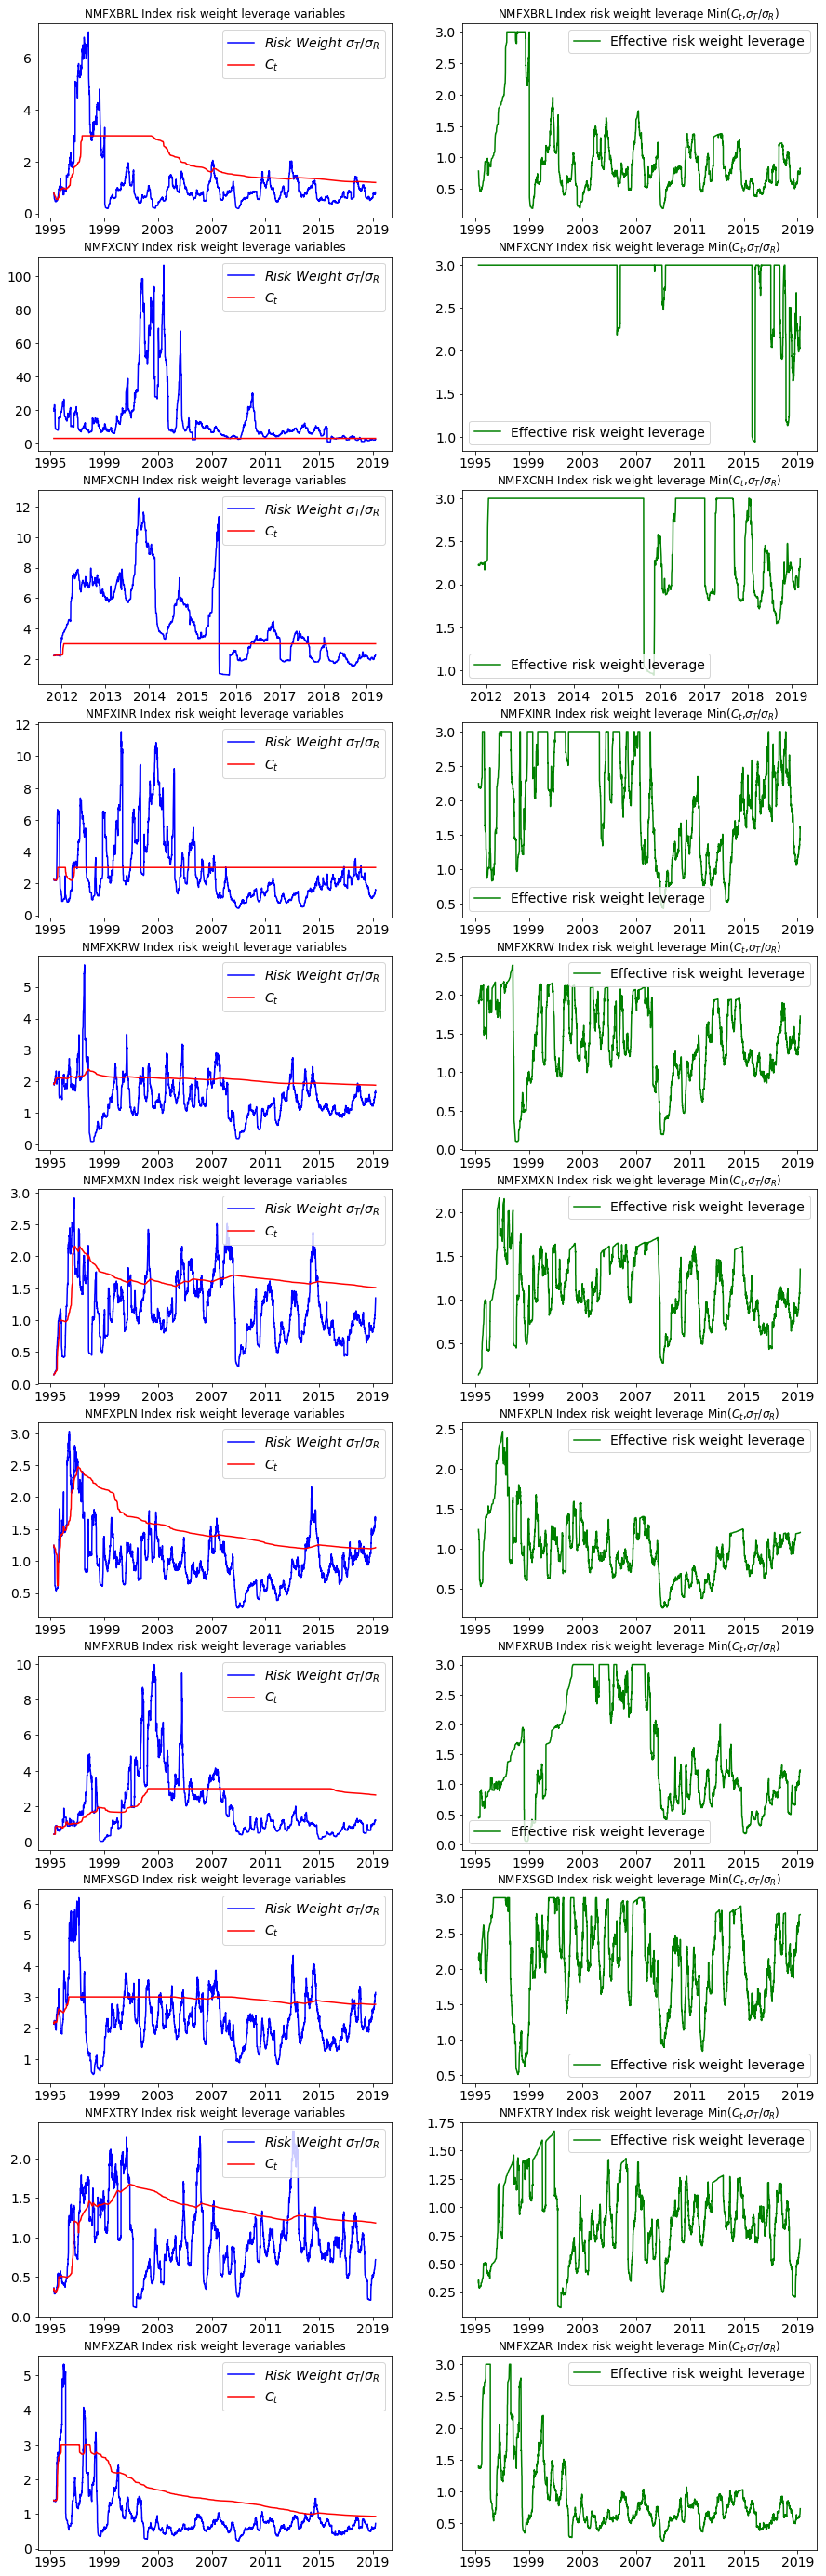

In [9]:
# Plot results
fig, ax = plt.subplots(11, 2, figsize=(15,50))

# NMFXBRL Index Risk Weight Leverage Plots
symbol = 'NMFXBRL Index'
ax[0, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[0, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[0, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[0, 0].legend(fontsize=14)
ax[0, 0].xaxis.set_tick_params(labelsize=14)
ax[0, 0].yaxis.set_tick_params(labelsize=14)

ax[0, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[0, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[0, 1].legend(fontsize=14)
ax[0, 1].xaxis.set_tick_params(labelsize=14)
ax[0, 1].yaxis.set_tick_params(labelsize=14)


# NMFXCNY Index Risk Weight Leverage Plots
symbol = 'NMFXCNY Index'
ax[1, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[1, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[1, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[1, 0].legend(fontsize=14)
ax[1, 0].xaxis.set_tick_params(labelsize=14)
ax[1, 0].yaxis.set_tick_params(labelsize=14)

ax[1, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[1, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[1, 1].legend(fontsize=14)
ax[1, 1].xaxis.set_tick_params(labelsize=14)
ax[1, 1].yaxis.set_tick_params(labelsize=14)


# NMFXCNH Index Risk Weight Leverage Plots
symbol = 'NMFXCNH Index'
ax[2, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[2, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[2, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[2, 0].legend(fontsize=14)
ax[2, 0].xaxis.set_tick_params(labelsize=14)
ax[2, 0].yaxis.set_tick_params(labelsize=14)

ax[2, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[2, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[2, 1].legend(fontsize=14)
ax[2, 1].xaxis.set_tick_params(labelsize=14)
ax[2, 1].yaxis.set_tick_params(labelsize=14)


# NMFXCNH Index Risk Weight Leverage Plots
symbol = 'NMFXINR Index'
ax[3, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[3, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[3, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[3, 0].legend(fontsize=14)
ax[3, 0].xaxis.set_tick_params(labelsize=14)
ax[3, 0].yaxis.set_tick_params(labelsize=14)

ax[3, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[3, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[3, 1].legend(fontsize=14)
ax[3, 1].xaxis.set_tick_params(labelsize=14)
ax[3, 1].yaxis.set_tick_params(labelsize=14)


# NMFXKRW Index Risk Weight Leverage Plots
symbol = 'NMFXKRW Index'
ax[4, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[4, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[4, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[4, 0].legend(fontsize=14)
ax[4, 0].xaxis.set_tick_params(labelsize=14)
ax[4, 0].yaxis.set_tick_params(labelsize=14)

ax[4, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[4, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[4, 1].legend(fontsize=14)
ax[4, 1].xaxis.set_tick_params(labelsize=14)
ax[4, 1].yaxis.set_tick_params(labelsize=14)


# NMFXMXN Index Risk Weight Leverage Plots
symbol = 'NMFXMXN Index'
ax[5, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[5, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[5, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[5, 0].legend(fontsize=14)
ax[5, 0].xaxis.set_tick_params(labelsize=14)
ax[5, 0].yaxis.set_tick_params(labelsize=14)

ax[5, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[5, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[5, 1].legend(fontsize=14)
ax[5, 1].xaxis.set_tick_params(labelsize=14)
ax[5, 1].yaxis.set_tick_params(labelsize=14)


# NMFXPLN Index Risk Weight Leverage Plots
symbol = 'NMFXPLN Index'
ax[6, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[6, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[6, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[6, 0].legend(fontsize=14)
ax[6, 0].xaxis.set_tick_params(labelsize=14)
ax[6, 0].yaxis.set_tick_params(labelsize=14)

ax[6, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[6, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[6, 1].legend(fontsize=14)
ax[6, 1].xaxis.set_tick_params(labelsize=14)
ax[6, 1].yaxis.set_tick_params(labelsize=14)


# NMFXRUB Index Risk Weight Leverage Plots
symbol = 'NMFXRUB Index'
ax[7, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[7, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[7, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[7, 0].legend(fontsize=14)
ax[7, 0].xaxis.set_tick_params(labelsize=14)
ax[7, 0].yaxis.set_tick_params(labelsize=14)

ax[7, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[7, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[7, 1].legend(fontsize=14)
ax[7, 1].xaxis.set_tick_params(labelsize=14)
ax[7, 1].yaxis.set_tick_params(labelsize=14)


# NMFXSGD Index Risk Weight Leverage Plots
symbol = 'NMFXSGD Index'
ax[8, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[8, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[8, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[8, 0].legend(fontsize=14)
ax[8, 0].xaxis.set_tick_params(labelsize=14)
ax[8, 0].yaxis.set_tick_params(labelsize=14)

ax[8, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[8, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[8, 1].legend(fontsize=14)
ax[8, 1].xaxis.set_tick_params(labelsize=14)
ax[8, 1].yaxis.set_tick_params(labelsize=14)


# NMFXTRY Index Risk Weight Leverage Plots
symbol = 'NMFXTRY Index'
ax[9, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[9, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[9, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[9, 0].legend(fontsize=14)
ax[9, 0].xaxis.set_tick_params(labelsize=14)
ax[9, 0].yaxis.set_tick_params(labelsize=14)

ax[9, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[9, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[9, 1].legend(fontsize=14)
ax[9, 1].xaxis.set_tick_params(labelsize=14)
ax[9, 1].yaxis.set_tick_params(labelsize=14)


# NMFXZAR Index Risk Weight Leverage Plots
symbol = 'NMFXZAR Index'
ax[10, 0].plot(rw_sigma_ratios_and_caps[symbol]["rw Sigma Ratio"], label = r"$Risk \ Weight \ \sigma_T/\sigma_R$", color = 'blue')
ax[10, 0].plot(rw_sigma_ratios_and_caps[symbol]["rwC_t"], label = r"$C_t$", color = 'red')
ax[10, 0].set_title(f"{symbol} risk weight leverage variables" )
ax[10, 0].legend(fontsize=14)
ax[10, 0].xaxis.set_tick_params(labelsize=14)
ax[10, 0].yaxis.set_tick_params(labelsize=14)

ax[10, 1].plot(rw_sigma_ratios_and_caps[symbol].min(axis=1), label = "Effective risk weight leverage", color = 'green')
ax[10, 1].set_title(f'{symbol} risk weight leverage Min($C_t$,$\sigma_T/\sigma_R$) ')
ax[10, 1].legend(fontsize=14)
ax[10, 1].xaxis.set_tick_params(labelsize=14)
ax[10, 1].yaxis.set_tick_params(labelsize=14)


# Final Trading Signal



Now we are ready to compute the final trading signal of the strategy. Here the position (i.e. nominal exposure) that we take in each currency forward is determined by the product of the trading signal and two different leverage adjustments $(i) \ \textit{risk weight leverage}$ denoted by $w$, and $(ii) \ \textit{volatility leverage}$ denoted by $L$. That is, the total exposure in asset $i$ at time $t$, $E_{t}^{i}$ is defined as:

$$E_{t}^{i}:=w_{t}^{i}L_{t}^{i}s_{t}^{i}$$

# Weekly rebalancing:

Here we use $\textit{weekly rebalancing}$, and therefore, we need to resample the daily trading signal to weekly frequency. More specifically, we create a set of $\textit{rebalancing dates}$ $\{t^{*}\}$. Then we take the signals for these dates $E_{t}^{i}(\{t^{*}\})$. The effective signal between rebalancing dates is then the signal from the immdetiately preceding rebalancing date. Exxactly, the effective signal, $E_{t}^{i}$ series is:

$$E_{t}^{i} = \left \{ E_i(t_1^{*}),\cdots ,E_i(t_1^{*}),E_i(t_2^{*}),\cdots ,E_i(t_2^{*}),\cdots,E_i(t_N^{*}),\cdots ,E_i(t_N^{*})  \right \}$$

where $t_1^{*}$ is the first rebalancing date and $t_N^{*}$ is the last rebalancing date. 


# Performance backtests

# Brazilian Real using Signal #1

In [18]:
import seaborn as sns

symbol      = 'NMFXBRL Index'
signal_name = "Signal_1"

# Volatility leverage
sigma_leverage = sigma_ratios_and_caps[symbol].min(axis=1)

# Raw risk weight leverage
risk_weight_leverage = rw_sigma_ratios_and_caps[symbol].min(axis=1)

# Total leverage
total_leverage = sigma_leverage#*risk_weight_leverage

# Raw momentum trading signal
signal   = momentum_signals[signal_name][symbol]

# Exposure
exposure = total_leverage*signal

# Strategy returns
start_returns  = ret[symbol]*exposure.shift(1)

# Signal vs underlying returns
look_forward = 5
reg_data_undrl = np.zeros((len(start_returns),2))
for i,date in enumerate(start_returns.index):
    x_point = signal.loc[date]
    y_point = ((1.0+ret[symbol].iloc[i:i+look_forward]).cumprod()-1)[-1]
    reg_data_undrl[i,0] = x_point
    reg_data_undrl[i,1] = y_point
    
# Signal vs strategy returns
look_forward = 5
reg_data_strat = np.zeros((len(start_returns),2))
for i,date in enumerate(start_returns.index):
    x_point = signal.loc[date]
    y_point = ((1.0+start_returns.iloc[i:i+look_forward]).cumprod()-1)[-1]
    reg_data_strat[i,0] = x_point
    reg_data_strat[i,1] = y_point



# Diagnostics plots for BRLUSD for Signal #1

Text(0.5,1,'Signal Strenght vs. Strategy performance')

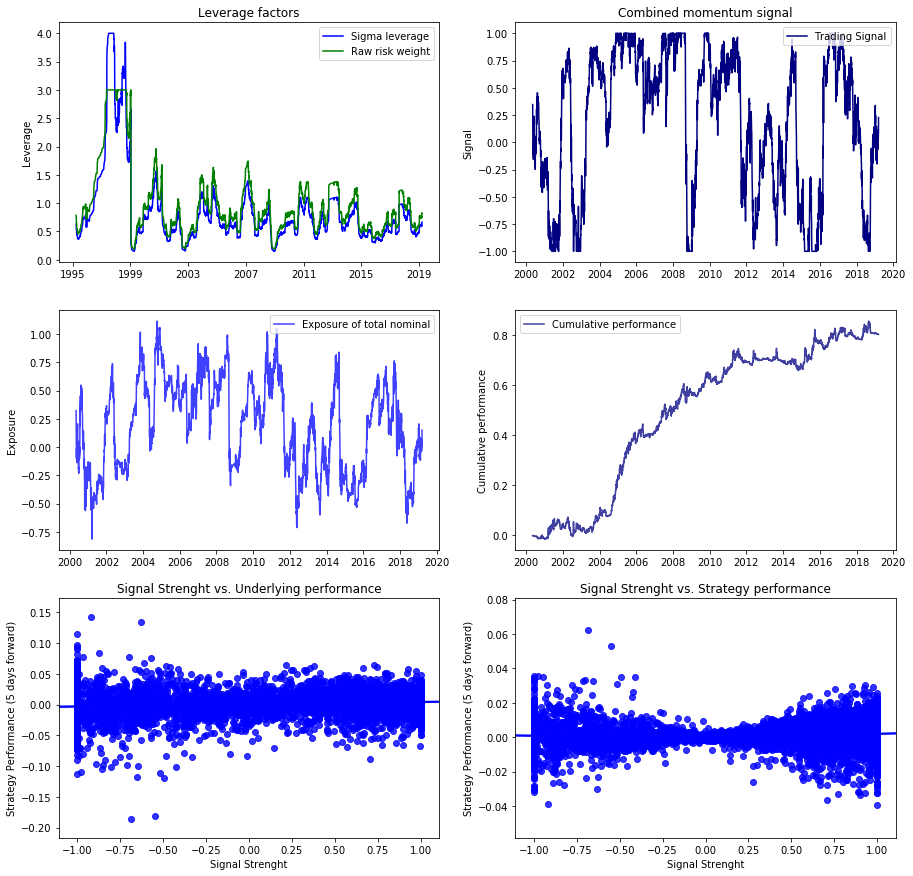

In [20]:
# Plot results
fig, ax = plt.subplots(3,2,figsize=(15,15))

ax[0, 0].plot(sigma_leverage,color='blue',label='Sigma leverage')
ax[0, 0].plot(risk_weight_leverage,color='green',label='Raw risk weight')
ax[0, 0].legend(loc = 1)
ax[0, 0].set_ylabel("Leverage")
ax[0, 0].set_title("Leverage factors")

ax[0, 1].plot(signal,color='navy',label='Trading Signal')
ax[0, 1].legend(loc = 1)
ax[0, 1].set_ylabel("Signal")
ax[0, 1].set_title("Combined momentum signal")

ax[1, 0].plot(exposure,color='blue',label='Exposure of total nominal',alpha=0.75)
ax[1, 0].legend(loc = 1)
ax[1, 0].set_ylabel("Exposure")

ax[1, 1].plot(start_returns.cumsum(),color='navy',label='Cumulative performance',alpha=0.75)
ax[1, 1].legend(loc = 2)
ax[1, 1].set_ylabel("Cumulative performance")


sns.regplot(x = reg_data_undrl[:,0], y = reg_data_undrl[:,1], scatter=True, order=2, ax = ax[2, 0], color = 'blue')
ax[2, 0].set_ylabel("Strategy Performance (5 days forward)")
ax[2, 0].set_xlabel("Signal Strenght")
ax[2, 0].set_title("Signal Strenght vs. Underlying performance")

sns.regplot(x = reg_data_strat[:,0], y = reg_data_strat[:,1], scatter=True, order=2, ax = ax[2, 1], color = 'blue')
ax[2, 1].set_ylabel("Strategy Performance (5 days forward)")
ax[2, 1].set_xlabel("Signal Strenght")
ax[2, 1].set_title("Signal Strenght vs. Strategy performance")



# Signal 1 Performance

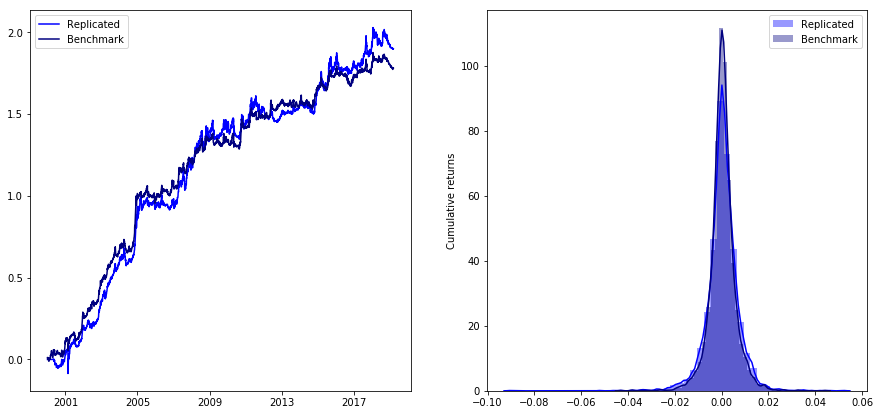

In [126]:

signal_name = "Signal_1"

strategy_returns = {}
for symbol in symbols:

    # Volatility leverage
    sigma_leverage = sigma_ratios_and_caps[symbol].min(axis=1)

    # Raw risk weight leverage
    risk_weight_leverage = rw_sigma_ratios_and_caps[symbol].min(axis=1)

    # Total leverage
    total_leverage = risk_weight_leverage

    # Raw momentum trading signal
    signal   = momentum_signals[signal_name][symbol]

    # Exposure
    exposure = total_leverage*signal
    exposure.index = pd.DatetimeIndex(exposure.index)
    
    # rebalancig dates
    rebal_dates = exposure.index[::5]
    
    E_at_rebal  = exposure.loc[rebal_dates]
    
    effective_exposure = E_at_rebal.reindex(exposure.index).fillna(method='ffill')
    
    # Strategy returns
    start_returns  = ret[symbol]*effective_exposure.shift(1)

    strategy_returns.update({symbol:start_returns.copy()})

# Concatenate data into pandas DataFrame
df = pd.DataFrame.from_dict(strategy_returns, orient = 'columns').fillna(0.0)

# Now what we want to do is to compare the returns of our replicated strategy against the benchmark. The problem we have is that
# the benchmark index has much higher volatility. Therefore, we need to scale our replicated strategy to have same volatility.

# We do this using data from the beginning of year 2000.
start_date = datetime(2000,1,1)

benchmark_returns = benchmark_data['NMEMMOMU Index'].pct_change(1).loc[start_date:]
strategy_returns  = df.mean(axis=1).loc[start_date:]

# Daily volatility of the benchmark index
sigma_bm = y_2.std()

# Daily volatility of our replicated strategy
sigma_s  = y_1.std()

# Scaling factor (benchmark volatility / strategy volatility)
scaling_factor = sigma_bm/sigma_s

scaled_strategy_returns = scaling_factor * strategy_returns

f, ax      = plt.subplots(1,2, figsize=(15,7))    
ax[0].plot(scaled_strategy_returns.cumsum(), color='blue',label='Replicated')
ax[0].plot(benchmark_returns.cumsum()      , color='navy',label='Benchmark')
ax[0].legend()
sns.distplot(scaled_strategy_returns.values, ax = ax[1], color = 'blue', label ='Replicated')
sns.distplot(benchmark_returns.values      , ax = ax[1], color = 'navy', label ='Benchmark' )
ax[1].set_ylabel('Cumulative returns')
ax[1].legend()




# Replication accuracy

To test our replication accuracy using Signal 1 we run a simple linear regression between the benchmark and the replicated strategy:

$$r_{BM} = \beta_0 + \beta_1 r_{Rep} + \epsilon_t $$

In [127]:
# Compute strategy returns using Signal 1
import statsmodels.api as sm

Y_data = benchmark_returns
X_data = scaled_strategy_returns

# We drop missing values
reg_data = pd.concat([Y_data,X_data],axis=1).dropna()
Y        = reg_data.iloc[:,0]
X        = reg_data.iloc[:,1]
X        = sm.add_constant(X)
model    = sm.OLS(Y,X)
results  = model.fit()


print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         NMEMMOMU Index   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                 1.212e+04
Date:                Sun, 17 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:21:42   Log-Likelihood:                 20878.
No. Observations:                4719   AIC:                        -4.175e+04
Df Residuals:                    4717   BIC:                        -4.174e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   4.23e-05      2.498      0.0

# Signal 2 Performance

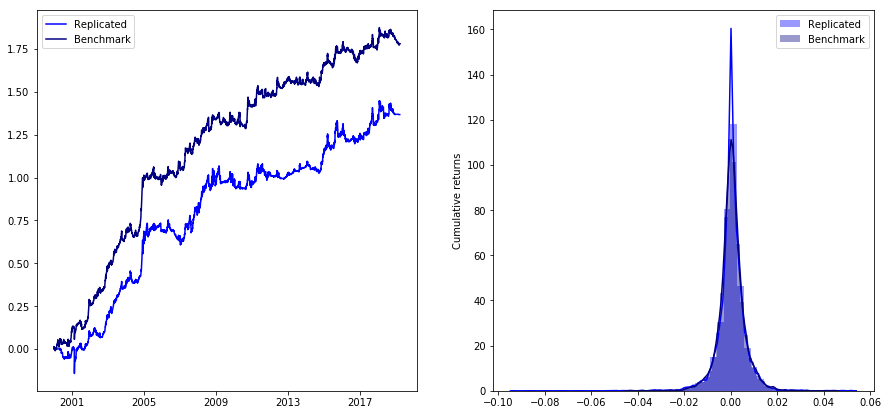

In [128]:

signal_name = "Signal_2"

strategy_returns = {}
for symbol in symbols:

    # Volatility leverage
    sigma_leverage = sigma_ratios_and_caps[symbol].min(axis=1)

    # Raw risk weight leverage
    risk_weight_leverage = rw_sigma_ratios_and_caps[symbol].min(axis=1)

    # Total leverage
    total_leverage = risk_weight_leverage

    # Raw momentum trading signal
    signal   = momentum_signals[signal_name][symbol]

    # Exposure
    exposure = total_leverage*signal
    exposure.index = pd.DatetimeIndex(exposure.index)
    
    # rebalancig dates
    rebal_dates = exposure.index[::5]
    
    E_at_rebal  = exposure.loc[rebal_dates]
    
    effective_exposure = E_at_rebal.reindex(exposure.index).fillna(method='ffill')
    
    # Strategy returns
    start_returns  = ret[symbol]*effective_exposure.shift(1)

    strategy_returns.update({symbol:start_returns.copy()})

# Concatenate data into pandas DataFrame
df = pd.DataFrame.from_dict(strategy_returns, orient = 'columns').fillna(0.0)

# Now what we want to do is to compare the returns of our replicated strategy against the benchmark. The problem we have is that
# the benchmark index has much higher volatility. Therefore, we need to scale our replicated strategy to have same volatility.

# We do this using data from the beginning of year 2000.
start_date = datetime(2000,1,1)

benchmark_returns = benchmark_data['NMEMMOMU Index'].pct_change(1).loc[start_date:]
strategy_returns  = df.mean(axis=1).loc[start_date:]

# Daily volatility of the benchmark index
sigma_bm = y_2.std()

# Daily volatility of our replicated strategy
sigma_s  = y_1.std()

# Scaling factor (benchmark volatility / strategy volatility)
scaling_factor = sigma_bm/sigma_s

scaled_strategy_returns = scaling_factor * strategy_returns

f, ax      = plt.subplots(1,2, figsize=(15,7))    
ax[0].plot(scaled_strategy_returns.cumsum(), color='blue',label='Replicated')
ax[0].plot(benchmark_returns.cumsum()      , color='navy',label='Benchmark')
ax[0].legend()
sns.distplot(scaled_strategy_returns.values, ax = ax[1], color = 'blue', label ='Replicated')
sns.distplot(benchmark_returns.values      , ax = ax[1], color = 'navy', label ='Benchmark' )
ax[1].set_ylabel('Cumulative returns')
ax[1].legend()

# Signal 3 Performance

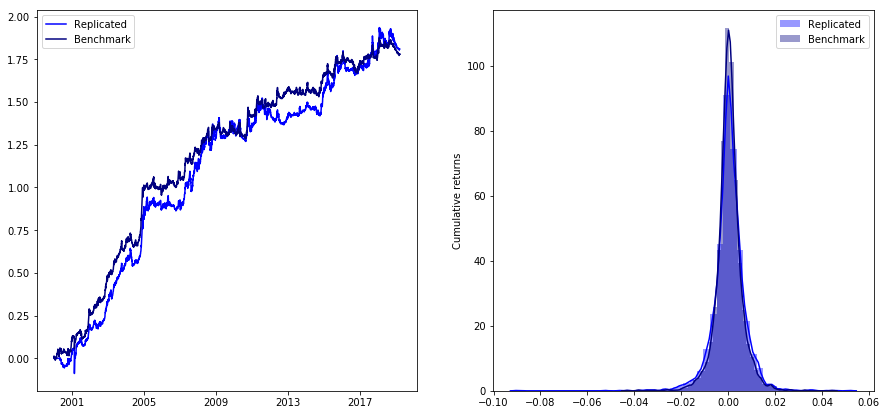

In [129]:

signal_name = "Signal_3"

strategy_returns = {}
for symbol in symbols:

    # Volatility leverage
    sigma_leverage = sigma_ratios_and_caps[symbol].min(axis=1)

    # Raw risk weight leverage
    risk_weight_leverage = rw_sigma_ratios_and_caps[symbol].min(axis=1)

    # Total leverage
    total_leverage = risk_weight_leverage

    # Raw momentum trading signal
    signal   = momentum_signals[signal_name][symbol]

    # Exposure
    exposure = total_leverage*signal
    exposure.index = pd.DatetimeIndex(exposure.index)
    
    # rebalancig dates
    rebal_dates = exposure.index[::5]
    
    E_at_rebal  = exposure.loc[rebal_dates]
    
    effective_exposure = E_at_rebal.reindex(exposure.index).fillna(method='ffill')
    
    # Strategy returns
    start_returns  = ret[symbol]*effective_exposure.shift(1)

    strategy_returns.update({symbol:start_returns.copy()})

# Concatenate data into pandas DataFrame
df = pd.DataFrame.from_dict(strategy_returns, orient = 'columns').fillna(0.0)

# Now what we want to do is to compare the returns of our replicated strategy against the benchmark. The problem we have is that
# the benchmark index has much higher volatility. Therefore, we need to scale our replicated strategy to have same volatility.

# We do this using data from the beginning of year 2000.
start_date = datetime(2000,1,1)

benchmark_returns = benchmark_data['NMEMMOMU Index'].pct_change(1).loc[start_date:]
strategy_returns  = df.mean(axis=1).loc[start_date:]

# Daily volatility of the benchmark index
sigma_bm = y_2.std()

# Daily volatility of our replicated strategy
sigma_s  = y_1.std()

# Scaling factor (benchmark volatility / strategy volatility)
scaling_factor = sigma_bm/sigma_s

scaled_strategy_returns = scaling_factor * strategy_returns

f, ax      = plt.subplots(1,2, figsize=(15,7))    
ax[0].plot(scaled_strategy_returns.cumsum(), color='blue',label='Replicated')
ax[0].plot(benchmark_returns.cumsum()      , color='navy',label='Benchmark')
ax[0].legend()
sns.distplot(scaled_strategy_returns.values, ax = ax[1], color = 'blue', label ='Replicated')
sns.distplot(benchmark_returns.values      , ax = ax[1], color = 'navy', label ='Benchmark' )
ax[1].set_ylabel('Cumulative returns')
ax[1].legend()


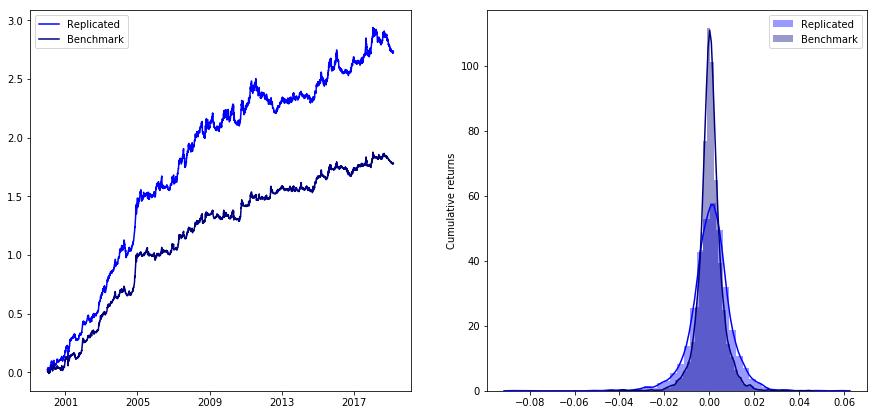

In [130]:
signal_name = "Signal_4"

strategy_returns = {}
for symbol in symbols:

    # Volatility leverage
    sigma_leverage = sigma_ratios_and_caps[symbol].min(axis=1)

    # Raw risk weight leverage
    risk_weight_leverage = rw_sigma_ratios_and_caps[symbol].min(axis=1)

    # Total leverage
    total_leverage = risk_weight_leverage

    # Raw momentum trading signal
    signal   = momentum_signals[signal_name][symbol]

    # Exposure
    exposure = total_leverage*signal
    exposure.index = pd.DatetimeIndex(exposure.index)
    
    # rebalancig dates
    rebal_dates = exposure.index[::5]
    
    E_at_rebal  = exposure.loc[rebal_dates]
    
    effective_exposure = E_at_rebal.reindex(exposure.index).fillna(method='ffill')
    
    # Strategy returns
    start_returns  = ret[symbol]*effective_exposure.shift(1)

    strategy_returns.update({symbol:start_returns.copy()})

# Concatenate data into pandas DataFrame
df = pd.DataFrame.from_dict(strategy_returns, orient = 'columns').fillna(0.0)

# Now what we want to do is to compare the returns of our replicated strategy against the benchmark. The problem we have is that
# the benchmark index has much higher volatility. Therefore, we need to scale our replicated strategy to have same volatility.

# We do this using data from the beginning of year 2000.
start_date = datetime(2000,1,1)

benchmark_returns = benchmark_data['NMEMMOMU Index'].pct_change(1).loc[start_date:]
strategy_returns  = df.mean(axis=1).loc[start_date:]

# Daily volatility of the benchmark index
sigma_bm = y_2.std()

# Daily volatility of our replicated strategy
sigma_s  = y_1.std()

# Scaling factor (benchmark volatility / strategy volatility)
scaling_factor = sigma_bm/sigma_s

scaled_strategy_returns = scaling_factor * strategy_returns

f, ax      = plt.subplots(1,2, figsize=(15,7))    
ax[0].plot(scaled_strategy_returns.cumsum(), color='blue',label='Replicated')
ax[0].plot(benchmark_returns.cumsum()      , color='navy',label='Benchmark')
ax[0].legend()
sns.distplot(scaled_strategy_returns.values, ax = ax[1], color = 'blue', label ='Replicated')
sns.distplot(benchmark_returns.values      , ax = ax[1], color = 'navy', label ='Benchmark' )
ax[1].set_ylabel('Cumulative returns')
ax[1].legend()


In [ ]:
signal_name = "Signal_5"

strategy_returns = {}
for symbol in symbols:

    # Volatility leverage
    sigma_leverage = sigma_ratios_and_caps[symbol].min(axis=1)

    # Raw risk weight leverage
    risk_weight_leverage = rw_sigma_ratios_and_caps[symbol].min(axis=1)

    # Total leverage
    total_leverage = risk_weight_leverage

    # Raw momentum trading signal
    signal   = momentum_signals[signal_name][symbol]

    # Exposure
    exposure = total_leverage*signal
    exposure.index = pd.DatetimeIndex(exposure.index)
    
    # rebalancig dates
    rebal_dates = exposure.index[::5]
    
    E_at_rebal  = exposure.loc[rebal_dates]
    
    effective_exposure = E_at_rebal.reindex(exposure.index).fillna(method='ffill')
    
    # Strategy returns
    start_returns  = ret[symbol]*effective_exposure.shift(1)

    strategy_returns.update({symbol:start_returns.copy()})

# Concatenate data into pandas DataFrame
df = pd.DataFrame.from_dict(strategy_returns, orient = 'columns').fillna(0.0)

# Now what we want to do is to compare the returns of our replicated strategy against the benchmark. The problem we have is that
# the benchmark index has much higher volatility. Therefore, we need to scale our replicated strategy to have same volatility.

# We do this using data from the beginning of year 2000.
start_date = datetime(2000,1,1)

benchmark_returns = benchmark_data['NMEMMOMU Index'].pct_change(1).loc[start_date:]
strategy_returns  = df.mean(axis=1).loc[start_date:]

# Daily volatility of the benchmark index
sigma_bm = y_2.std()

# Daily volatility of our replicated strategy
sigma_s  = y_1.std()

# Scaling factor (benchmark volatility / strategy volatility)
scaling_factor = sigma_bm/sigma_s

scaled_strategy_returns = scaling_factor * strategy_returns

f, ax      = plt.subplots(1,2, figsize=(15,7))    
ax[0].plot(scaled_strategy_returns.cumsum(), color='blue',label='Replicated')
ax[0].plot(benchmark_returns.cumsum()      , color='navy',label='Benchmark')
ax[0].legend()
sns.distplot(scaled_strategy_returns.values, ax = ax[1], color = 'blue', label ='Replicated')
sns.distplot(benchmark_returns.values      , ax = ax[1], color = 'navy', label ='Benchmark' )
ax[1].set_ylabel('Cumulative returns')
ax[1].legend()


# Performance Statistics

In [90]:
from scipy.stats import skew,kurtosis

def compute_statistics(returns):

    # For maximum drawdown we need compounded return series (not strictly correct but hey whatever)
    xs = (1.0 + returns).cumprod()
    
    start_date = xs.head(1).index[0]
    end_date   = xs.tail(1).index[0]
    years      = (end_date - start_date).days/365
    
    # Sample mean
    mu_avg  = returns.mean()*252
    
    # Cumulative aggregate growth rate
    mu_cagr = (xs.tail(1).values[0]/xs.head(1).values[0])**(1.0/years)-1.0
    
    # End of maximum drawdown
    i       = np.argmax(np.maximum.accumulate(xs) - xs) 
    
    # Start of maximum drawdown
    j       = np.argmax(xs[:i])
    
    # Magnitude of maximum drawdown
    max_dd  = (xs[i] - xs[j])/xs[j]
    
    # Volatility of the returns
    vol     = returns.std()*np.sqrt(250)
     
    # Sharpe ratio    
    sharpe  = mu_cagr/vol
    
    result = {}
    
    result.update({'Average_return' :round(100.0*mu_avg ,2) })
    result.update({'CAGR'           :round(100.0*mu_cagr,2) })
    result.update({'Volatility'     :round(100.0*vol,2)     })
    result.update({'Sharpe'         :round(mu_cagr/vol,2)   })
    result.update({'MaxDD'          :round(100.0*max_dd,2)  })
    result.update({'CalmarRatioAvg' :round(mu_avg  / abs(max_dd),3) })
    result.update({'CalmarRatioCAGR':round(mu_cagr / abs(max_dd),3) })
    result.update({'MaxDDperVol'    :round(max_dd/vol,2)               })
    result.update({'Skew'           :round(skew(xs),2)                 })
    result.update({'ExcessKurtosis' :round(kurtosis(xs,fisher=True),2) })
    
    return result


In [37]:
signal_1_statistics  = compute_statistics(signal_1_returns.dropna())
signal_2_statistics  = compute_statistics(signal_2_returns.dropna())
signal_3_statistics  = compute_statistics(signal_3_returns.dropna())
#benchmark_statistics = compute_statistics(benchmark_returns.dropna())


df_1  = pd.DataFrame.from_dict(signal_1_statistics  , orient='index', columns=['Signal 1'])
df_2  = pd.DataFrame.from_dict(signal_2_statistics  , orient='index', columns=['Signal 2'])
df_3  = pd.DataFrame.from_dict(signal_3_statistics  , orient='index', columns=['Signal 3'])
#df_bm = pd.DataFrame.from_dict(benchmark_statistics , orient='index', columns=['NMEDMG3E Index'])

summary = pd.concat([df_1,df_2,df_3],axis=1)

print(summary)

                 Signal 1  Signal 2  Signal 3
Average_return      3.210     2.430     3.150
CAGR                3.190     2.410     3.120
Volatility          4.590     3.870     4.550
Sharpe              0.690     0.620     0.690
MaxDD              -8.900    -5.930    -8.850
CalmarRatioAvg      0.361     0.410     0.355
CalmarRatioCAGR     0.359     0.407     0.353
MaxDDperVol        -1.940    -1.530    -1.940
Skew               -0.200    -0.130    -0.210
ExcessKurtosis     -1.500    -1.530    -1.500
